In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [5]:
h = 0.01
rng = np.random.RandomState(1234)

# Data generation

In [6]:
# Generate a solution to x'' - 9.81 = 0
x0 = 0.5
v0 = 0.1
g = 9.81
sigma = 0.01  # Noise level
N_samples = 10

t_grid = np.arange(0, 1, h)
x_grid = x0 + t_grid*v0 + 0.5*(-g)*t_grid**2

N_grid = t_grid.shape[0]

t_samples = rng.choice(t_grid, size=N_samples, replace=False)
t_samples = np.array(t_samples)
x_noiseless_samples = x0 + t_samples * v0 + 0.5 * (-g) * t_samples**2
x_noisy_samples = x_noiseless_samples + rng.normal(scale=sigma, size=(N_samples,))

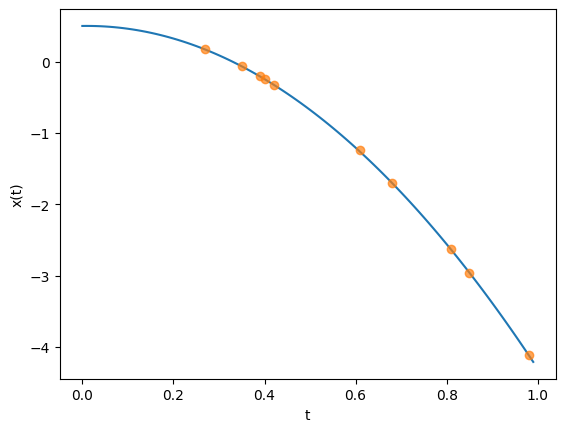

In [7]:
fig, ax = plt.subplots()
ax.plot(t_grid, x_grid, ls='-', marker='none')
ax.plot(t_samples, x_noisy_samples, ls='none', marker='o', alpha=0.7)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')

plt.show()

# Numerical solution

In [121]:
# Want to optimize a vector, x_soln.
# This will be initialized to interpolate between our datapoints, and will
# gradually be forced to obey our candidate ODE, while minimizing the L2 loss.
x_soln_grid = torch.randn(t_grid.shape, dtype=torch.float32, requires_grad=True)
N_iter = 10000

#optimizer = torch.optim.SGD(lr=0.25e-6, momentum=0.0, params=[x_soln_grid])
optimizer = torch.optim.LBFGS(lr=1, history_size=10, params=[x_soln_grid])
#optimizer = torch.optim.Adam(lr=1e-3, params=[x_soln_grid])
#optimizer = torch.optim.RMSprop(lr=1e-2, alpha=0.9, momentum=0.0, params=[x_soln_grid])
#optimizer = torch.optim.Adagrad(lr=1e-2, params=[x_soln_grid])
w_ode_loss = 0.0  # Weight assigned to the ODE part of the loss. Will vary over optimization.

# optimizer1 = torch.optim.Adam(lr=1e-2, params=[x_soln_grid])
# optimizer2 = torch.optim.Adam(lr=1e-3, params=[x_soln_grid])
# optimizer3 = torch.optim.Adam(lr=1e-4, params=[x_soln_grid])

In [122]:
x_data_grid = torch.zeros(t_grid.shape, dtype=torch.float32, requires_grad=False)
data_flag_grid = torch.zeros(t_grid.shape, dtype=torch.float32, requires_grad=False)
# TODO - the population method is inefficient, but it'll do for now.
for i in range(len(t_grid)):
    if t_grid[i] in t_samples:
        j = list(t_samples).index(t_grid[i])  # Index within the sparse samples
        x_data_grid[i] = x_noisy_samples[j]
        data_flag_grid[i] = 1.0

# This allows us to compute the second derivative at every interior point of the domain.
second_deriv_mat = torch.zeros((N_grid-2, N_grid), dtype=torch.float32, requires_grad=False)
for i in range(N_grid-2):
    second_deriv_mat[i, i] = -0.5
    second_deriv_mat[i, i+1] = +1.0
    second_deriv_mat[i, i+2] = -0.5

In [117]:
# for it in tqdm(range(N_iter)):
#     loss_data = 0.5 * torch.sum(data_flag_grid * (x_soln_grid - x_data_grid)**2)
#     # Compute the deviation from the ODE for every point in the interior.
#     # This is the difference between the left and right sides of the discretized ODE.
#     ode_deviation = (second_deriv_mat @ x_soln_grid)/h**2 + 0.5 * (-g)
#     loss_ode = 0.5 * h * torch.sum(torch.abs(ode_deviation))

#     # print(loss_data)
#     # print(loss_ode)
#     # break

#     w_ode_loss = 0.5 # 0.99 * (it / (N_iter-1))
#     loss = (1 - w_ode_loss) * loss_data + w_ode_loss * loss_ode

#     optimizer.zero_grad()
#     loss.backward()
#     #break
#     optimizer.step()

100%|████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 430.12it/s]

tensor(0.0761, grad_fn=<MulBackward0>)
tensor(0.1447, grad_fn=<MulBackward0>)


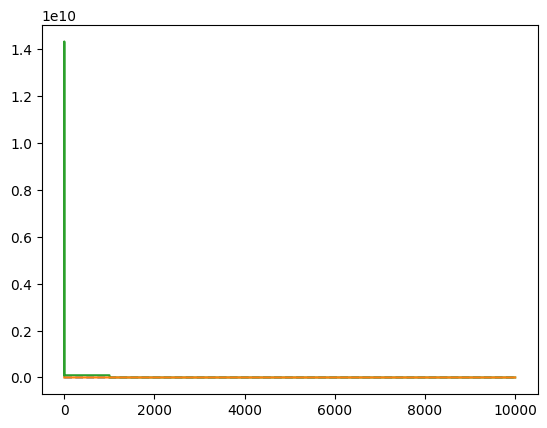

In [123]:
#N_iter = 5

#soln_hist = [x_soln_grid.detach().numpy().copy()]

loss_data_hist = []
loss_ode_hist = []
w_ode_hist = []

for it in tqdm(range(N_iter)):
    loss_data = 0.5 * torch.sum(data_flag_grid * (x_soln_grid - x_data_grid)**2)
    # Compute the deviation from the ODE for every point in the interior.
    # This is the difference between the left and right sides of the discretized ODE.
    ode_deviation = (second_deriv_mat @ x_soln_grid)/h**2 + 0.5 * (-g)
    loss_ode = 0.5 * h * torch.sum(ode_deviation**2)

    loss_data_hist.append(loss_data.detach().item())
    loss_ode_hist.append(loss_ode.detach().item())
    
    if it == N_iter-1:
         print(loss_data)
         print(loss_ode)
    #     break

    # if it < 0.1*N_iter:
    #     w_ode_loss = 0.0
    # elif it < 0.9*N_iter:
    #     w_ode_loss = (it - 0.1*N_iter) / (0.8*N_iter)
    # #w_ode_loss = min(0.99 * (it / 2*(N_iter-1)), 1.0)
    # else:
    #     w_ode_loss = 1.0
    if it < 0.1*N_iter:
        w_ode_loss = 0.0
    elif it < 0.9*N_iter:
        w_ode_loss = 0.25
    #w_ode_loss = min(0.99 * (it / 2*(N_iter-1)), 1.0)
    else:
        w_ode_loss = 1.0

    w_ode_hist.append(w_ode_loss)

    loss = (1 - w_ode_loss) * loss_data + w_ode_loss * loss_ode
    
    optimizer.zero_grad()
    loss.backward()
    #torch.nn.utils.clip_grad_value_(x_soln_grid, 1e3)
    optimizer.step(lambda: (1 - w_ode_loss) * 0.5 * torch.sum(data_flag_grid * (x_soln_grid - x_data_grid)**2) + w_ode_loss* 0.5*h*torch.sum(((second_deriv_mat @ x_soln_grid)/h**2 + 0.5 * (-g))**2))

    # print(x_soln_grid)
    # print(x_soln_grid.grad)
    
    if x_soln_grid.isnan().any().item():
        print(f'NaNs after it={it}')
        break

    #soln_hist.append(x_soln_grid.detach().numpy().copy())

fig, ax = plt.subplots()
ax.plot(loss_data_hist, ls='--', marker='none', color='tab:blue')
ax.plot(loss_ode_hist, ls='-', marker='none', color='tab:green')
ax.plot(w_ode_hist, ls='-', marker='none', color='tab:orange')

(0.0, 10.0)

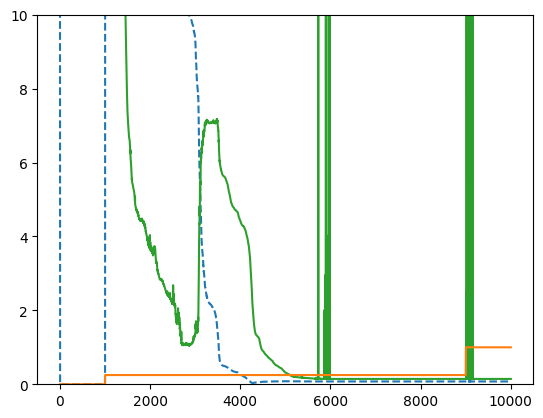

In [124]:
fig, ax = plt.subplots()
ax.plot(loss_data_hist, ls='--', marker='none', color='tab:blue')
ax.plot(loss_ode_hist, ls='-', marker='none', color='tab:green')
ax.plot(w_ode_hist, ls='-', marker='none', color='tab:orange')
ax.set_ylim(0, 10)

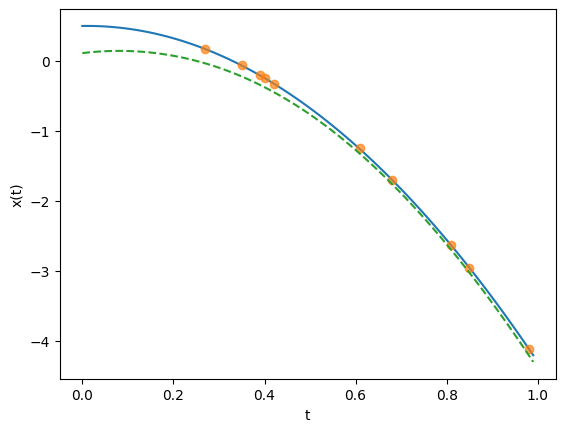

In [125]:
fig, ax = plt.subplots()
ax.plot(t_grid, x_grid, ls='-', marker='none')
ax.plot(t_samples, x_noisy_samples, ls='none', marker='o', alpha=0.7)
ax.plot(t_grid, x_soln_grid.detach().numpy(), ls='--', marker='none')
ax.set_xlabel('t')
ax.set_ylabel('x(t)')

plt.show()

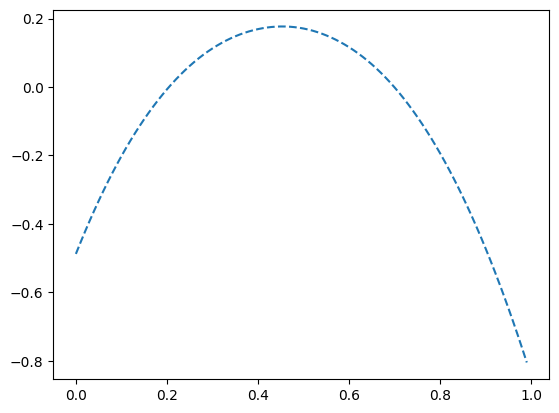

In [56]:
plt.plot(t_grid, x_soln_grid.detach().numpy(), ls='--', marker='none')

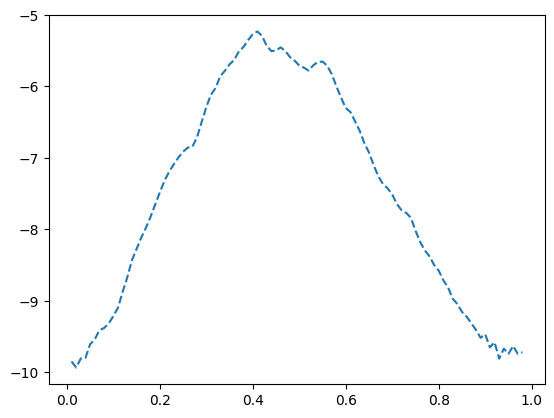

In [57]:
x_det = x_soln_grid.detach().numpy()
plt.plot(t_grid[1:-1], h**-2 * (x_det[:-2] - 2*x_det[1:-1] + x_det[2:]), ls='--', marker='none')

In [89]:
x_soln_grid.grad

tensor([ -25.,   75.,  -50.,  -50.,  100.,  -50.,  -50.,  100., -100.,  100.,
         -50.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  -50.,  100.,  -50.,  -50.,  100., -100.,  100.,
         -50.,    0.,  -50.,  100., -100.,  100., -100.,   50.,   25.,  -25.])